In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosBlue.xlsx.pkl')
df

In [ ]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,0,2023-01-20,372.0,376.0
1,1,2023-01-20,370.0,374.0
2,2,2023-01-19,373.0,377.0
3,3,2023-01-18,374.0,378.0
4,4,2023-01-17,366.0,370.0


In [ ]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [ ]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,0,2023-01-20,372.00,376.00
1,1,2023-01-20,370.00,374.00
2,2,2023-01-19,373.00,377.00
3,3,2023-01-18,374.00,378.00
4,4,2023-01-17,366.00,370.00
...,...,...,...,...
1268,1268,2018-01-08,19.18,19.58
1269,1269,2018-01-05,19.05,19.45
1270,1270,2018-01-04,19.01,19.41
1271,1271,2018-01-03,18.89,19.29


In [ ]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,0,2023-01-20,376.00
1,1,2023-01-20,374.00
2,2,2023-01-19,377.00
3,3,2023-01-18,378.00
4,4,2023-01-17,370.00
...,...,...,...
1268,1268,2018-01-08,19.58
1269,1269,2018-01-05,19.45
1270,1270,2018-01-04,19.41
1271,1271,2018-01-03,19.29


In [ ]:
df = df.sort_values(by='ds')

In [ ]:
df['y'].round(2).describe()

count    1273.000000
mean      131.093409
std        89.980592
min        19.250000
25%        43.800000
50%       132.000000
75%       195.000000
max       378.000000
Name: y, dtype: float64

In [ ]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

c:\Users\rodri\anaconda3.1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
19:42:38 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1229,2023-01-17
1230,2023-01-18
1231,2023-01-19
1232,2023-01-20
1233,2023-12-31


In [ ]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,29.360837,15.844233,43.678599
1,2018-01-03,30.326837,17.078552,43.338012
2,2018-01-04,30.505923,17.605565,44.502380
3,2018-01-05,30.870810,16.769221,43.776346
4,2018-01-08,30.389987,16.786051,43.669891


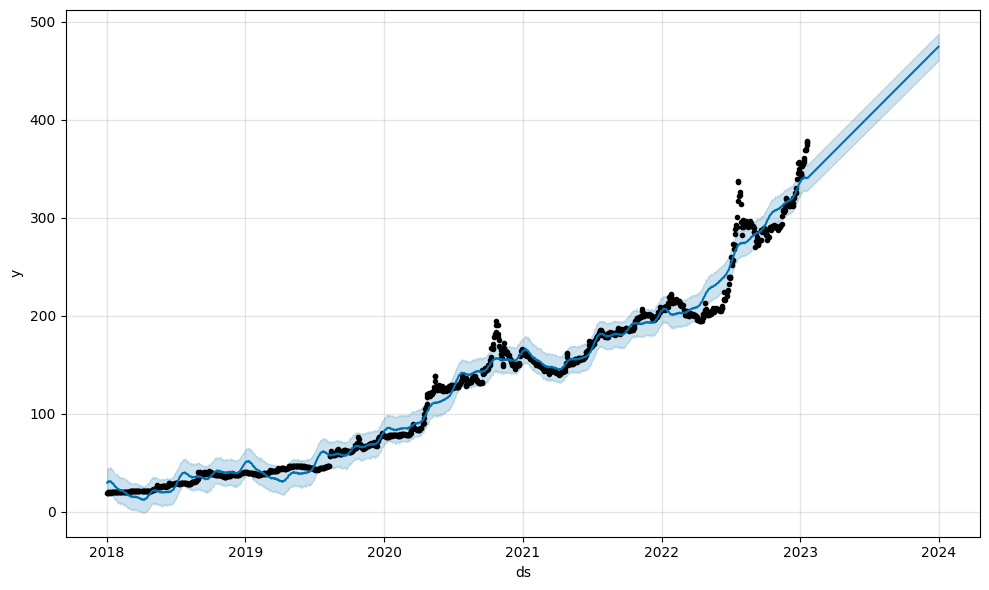

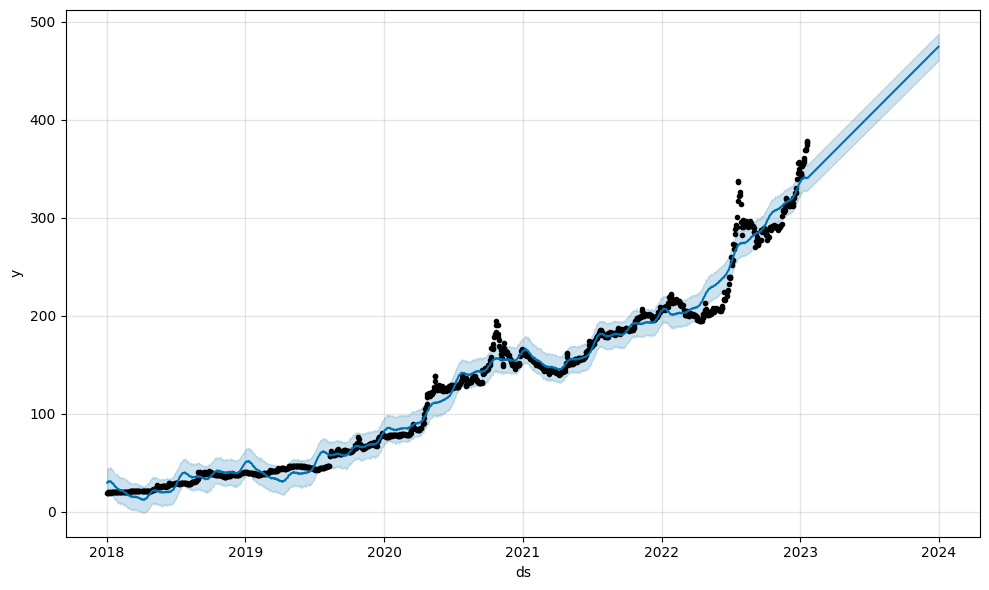

In [ ]:
prophet_model.plot(pred)

In [ ]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [ ]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

19:42:46 - cmdstanpy - INFO - Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing


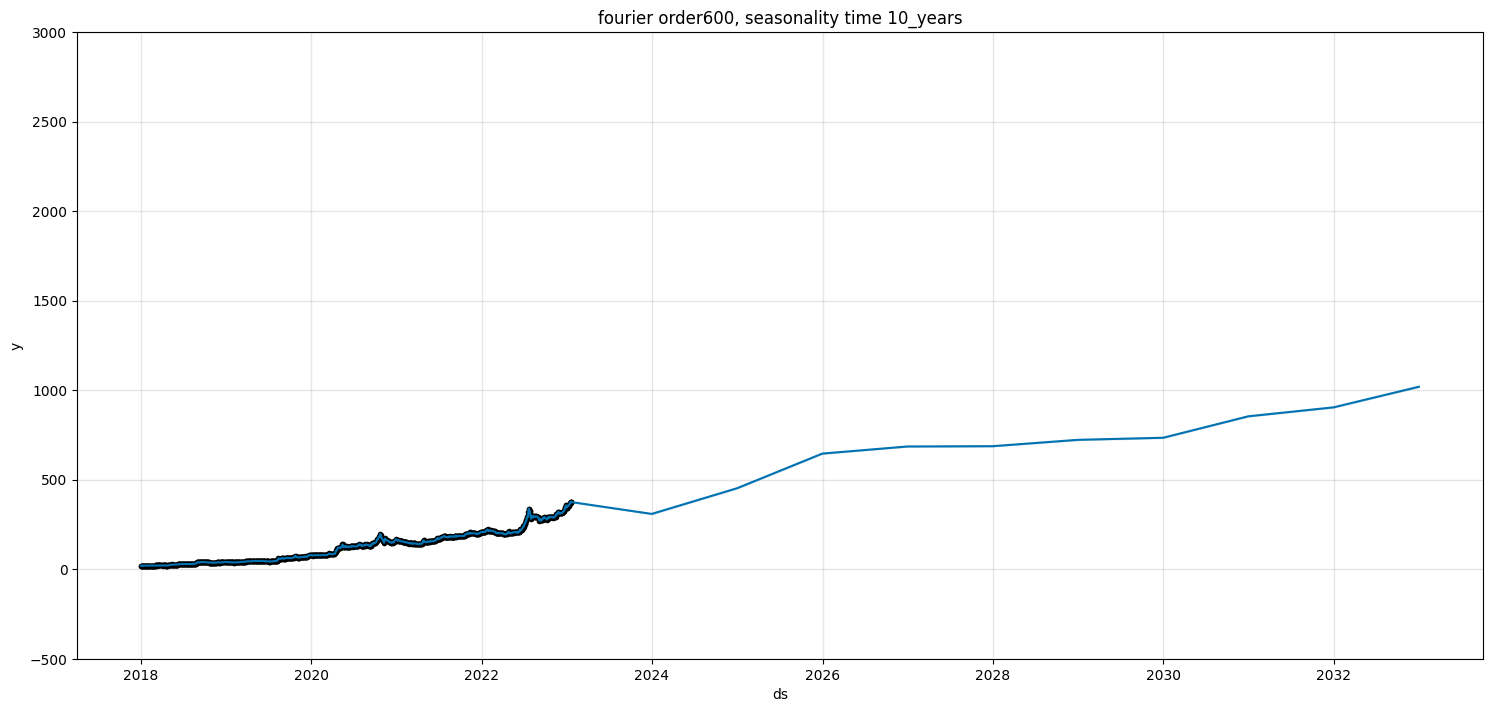

Total Execution Time 60.554593563079834 seconds


In [ ]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

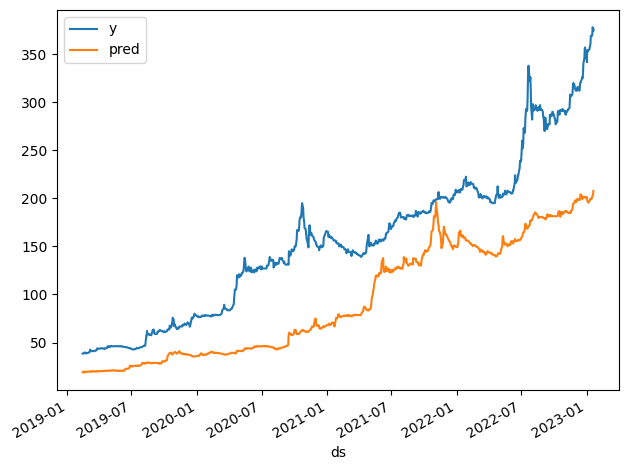

In [ ]:
plot_valid(validation_set, 1000, ten_years)

In [ ]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,29.360837
1,2018-01-03,30.326837
2,2018-01-04,30.505923
3,2018-01-05,30.870810
4,2018-01-08,30.389987
...,...,...
1229,2023-01-17,340.441757
1230,2023-01-18,340.862539
1231,2023-01-19,340.546079
1232,2023-01-20,340.475155


In [ ]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1272,2018-01-02,19.25
1271,2018-01-03,19.29
1270,2018-01-04,19.41
1269,2018-01-05,19.45
1268,2018-01-08,19.58
...,...,...
4,2023-01-17,370.00
3,2023-01-18,378.00
2,2023-01-19,377.00
1,2023-01-20,374.00


In [ ]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,29.360837
1,2018-01-03,30.326837
2,2018-01-04,30.505923
3,2018-01-05,30.870810
4,2018-01-08,30.389987
...,...,...
1228,2023-01-16,340.389316
1229,2023-01-17,340.441757
1230,2023-01-18,340.862539
1231,2023-01-19,340.546079


In [ ]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [ ]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_2676\2616818827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_2676\2616818827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())


In [ ]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_2676\476390056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
C:\Users\rodri\AppData\Local\Temp\ipykernel_2676\476390056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)


In [ ]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  3.6871032790308047
Mean Squared Error:  53.25478373503179
Root Mean Squared Error:  7.297587528425527


In [ ]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
537,537,2021-01-04,159.0,165.0
536,536,2021-01-05,154.0,160.0
535,535,2021-01-06,154.0,160.0
534,534,2021-01-07,156.0,162.0
533,533,2021-01-08,155.0,161.0
...,...,...,...,...
4,4,2023-01-17,366.0,370.0
3,3,2023-01-18,374.0,378.0
2,2,2023-01-19,373.0,377.0
1,1,2023-01-20,370.0,374.0


19:43:46 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing


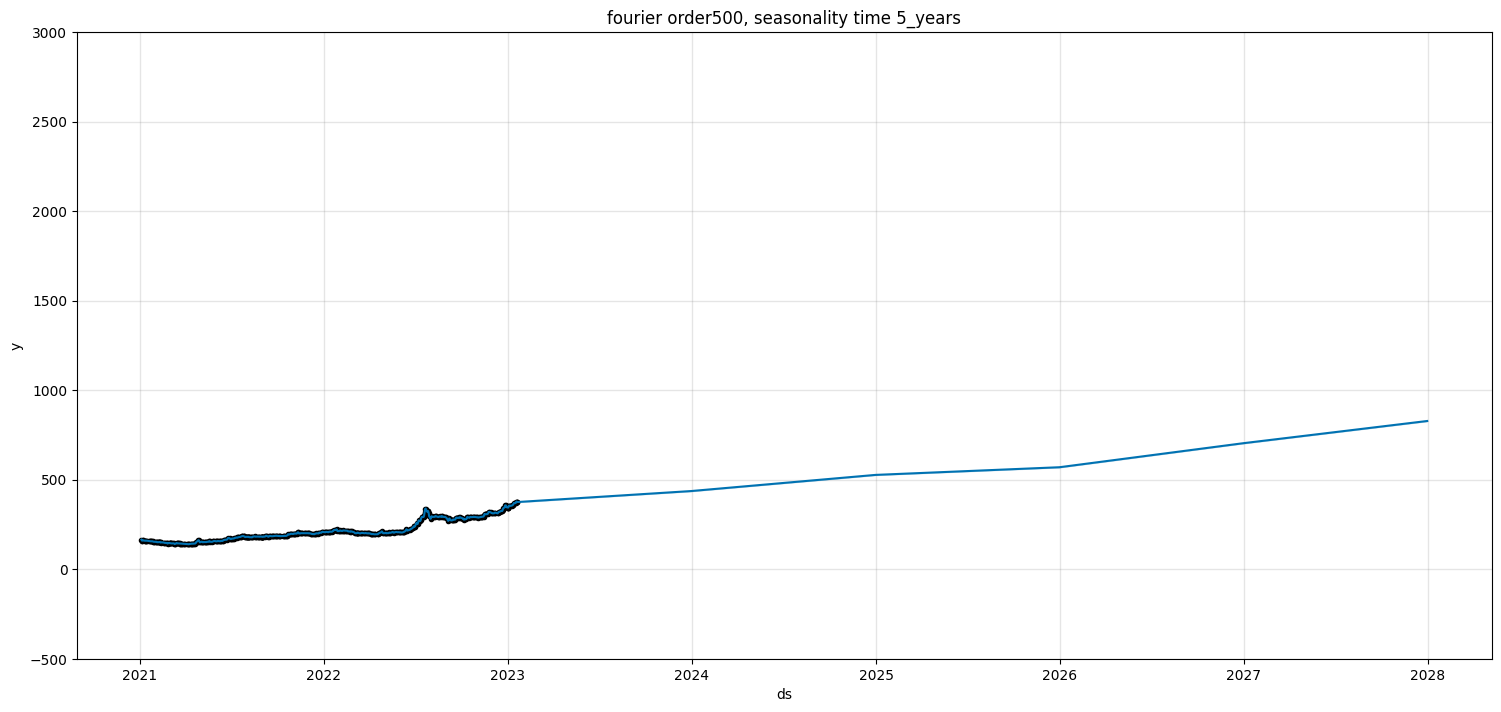

Total Execution Time 11.27160358428955 seconds


In [ ]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

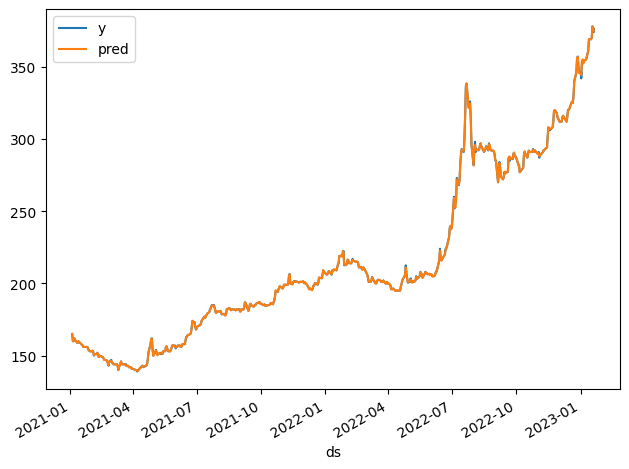

In [ ]:
plot_valid(validation_set, 1000, five_years_model)

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

model = Prophet()
model.fit(df)

df_cv = cross_validation(model, initial='360 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, rolling_window=0.1) 
 
df_p.head()

19:46:46 - cmdstanpy - INFO - Chain [1] start processing
19:46:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

19:46:47 - cmdstanpy - INFO - Chain [1] start processing
19:46:47 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,167.145413,12.928473,12.758302,0.059272,0.060695,0.061129,0.0
1,36 days,169.378815,13.014562,12.849190,0.059780,0.060772,0.061667,0.0
2,41 days,166.616969,12.908020,12.722512,0.059309,0.060772,0.061171,0.0
3,42 days,161.600765,12.712229,12.483187,0.058322,0.060695,0.060134,0.0
4,43 days,153.346677,12.383323,12.059645,0.056486,0.058843,0.058212,0.0


In [ ]:
from sklearn.metrics import mean_squared_error
pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


Mean Absolute Error:  4.429009815672443
Mean Squared Error:  83.4639793658698
Root Mean Squared Error:  9.13586226723399


C:\Users\rodri\AppData\Local\Temp\ipykernel_17500\4273972159.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_17500\4273972159.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_17500\4273972159.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [ ]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [ ]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=140)

In [ ]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [ ]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:20 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,383.009680
1,382.424255
2,384.098123
3,384.283372
4,380.111616
...,...
86,375.136645
87,376.017459
88,378.979720
89,380.902105


In [ ]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-01-25,383.009680
2023-01-26,382.424255
2023-01-27,384.098123
2023-01-28,384.283372
2023-01-29,380.111616
...,...
2023-04-21,375.136645
2023-04-22,376.017459
2023-04-23,378.979720
2023-04-24,380.902105


In [ ]:
values_new.to_excel("data/xlsx/values_newBlue.xlsx")

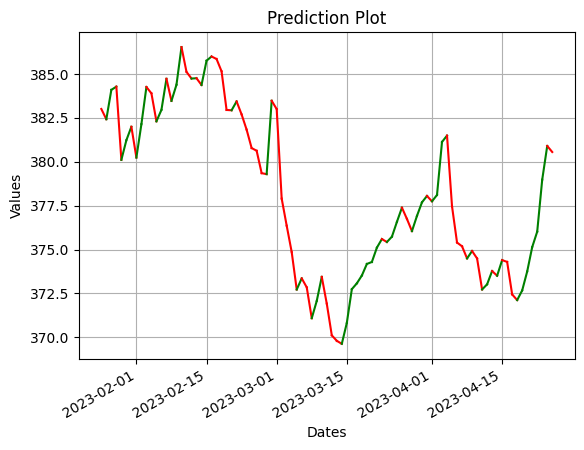

In [ ]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Blue', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [ ]:
with open('data/html/Predicciones/Pred_DolarBlue.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))